In [718]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import graphviz

from sklearn import tree, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, Imputer

In [654]:
def convert_raw_csv(input_file, output_file):
    df = pd.read_csv(input_file, header = 0, sep=',', thousands=',')
    toScale = ['attr1_1','sinc1_1','intel1_1','fun1_1','amb1_1','shar1_1', 
           'attr2_1','sinc2_1','intel2_1','fun2_1','amb2_1','shar2_1', 
           'attr3_1','sinc3_1','intel3_1','fun3_1','amb3_1', 
           'attr4_1','sinc4_1','intel4_1','fun4_1','amb4_1','shar4_1', 
           'attr5_1','sinc5_1','intel5_1','fun5_1','amb5_1']
    
    def scaleAttrs(r):
        for group in [toScale[0:6],toScale[6:12],toScale[12:17],toScale[17:23],toScale[23:28]]:
            s = np.sum(r[group])
            assert not s == 0 and not s == np.isnan(s)
            r[group] = r[group]/s
        return r
    
    df[toScale] = df[toScale].apply(scaleAttrs, axis=1)
    df.to_csv(output_file, index=False)

In [655]:
def with_pAge(df):
    ages = df[['iid','age']].groupby(['iid']).mean()
    df['pAge'] = df['pid'].apply(lambda x: math.nan if math.isnan(x) else ages.age[x]) 
    return df

In [656]:
def impute(X):
    # Copy to avoid looping over the array we're modifying
    cols = X.columns.values
    for col in cols:
        if X[col].dtypes=='object':
            #print('Classifying {0}'.format(col))
            X = X.drop(col, axis=1)
            print('Dropping column {0}'.format(col))
            # This is really heavy
            #classes = X[col].str.get_dummies().rename(columns=lambda x: 'field-{0}'.format(x).replace(' ',''))
            #X = pd.concat([X,classes])
        elif X[col].dtypes=='float64' and X[col].isnull().values.any():
            assert not col == 'iid' and not col == 'id' and not col == 'idg'
            #print('Imputing {0}'.format(col))
            # fill in missing values
            if col == 'field_cd' or \
                col == 'gender' or \
                col == 'undergrd' or \
                col == 'race' or \
                col == 'from' or \
                col == 'career_c':
                X[[col]]=Imputer(missing_values='NaN', strategy='most_frequent', axis=0).fit_transform(X[[col]])
            else:
                X[[col]]=Imputer(missing_values='NaN', strategy='mean', axis=0).fit_transform(X[[col]])
    return X

In [657]:
# Preprocess data 
def preprocess(df):
    return impute(df.drop(columns=['iid', 'id', 'idg', 'condtn', 'wave', 'round', 'position', 
                            'positin1', 'order', 'partner', 'pid', 'match', 
                            'zipcode', # zipcode -> income 
                            #'undergra', -> {mn_sat, tuition} 
                            'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob',
                            'match', 'dec',
                            #'gender', 
                            'you_call', 'them_cal', 'date_3', 'numdat_3', 'num_in_3',
                           ], errors='ignore'))

In [658]:
def splitBy(df, attr):
    return df.drop([attr], axis=1), df[attr]

In [757]:
def model(X,y,test_size=0.2,random_state=0,min_samples_split=0.02, max_depth=10, accuracy_file=None, print_stats=True):
    X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=test_size, random_state=random_state)

    clf = tree.DecisionTreeClassifier(min_samples_split=min_samples_split, max_depth=max_depth)
    clf = clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_predict)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict).ravel()/len(y_test)
    if print_stats:
        accuracy_str = """Accuracy: {0:.2f}%
True negatives: {1:.2f}%\tFalse negatives: {2:.2f}%
False positives: {3:.2f}%\tTrue positives: {4:.2f}%\n""".format(
            accuracy*100, tn*100, fp*100, fn*100, tp*100)
        print(accuracy_str)
    
    if not accuracy_file == None:
        with open(accuracy_file, 'w') as f:
            f.write(accuracy_str)
    return clf

In [660]:
def vizualize(model, columns, out_file=None):
    graph = graphviz.Source(
        tree.export_graphviz(model, out_file=None,
                                feature_names=columns,
                                filled=True, rounded=True,
                                special_characters=True))
    if not out_file == None:
        graph.render(out_file)
        
    return graph  

In [661]:
# Scaling the attrs turned out to be really slow, so store preprocessed data.
#convert_raw_csv("data.csv", "data_converted.csv")

In [662]:
df = pd.read_csv("data_converted.csv", header=0, sep=',')

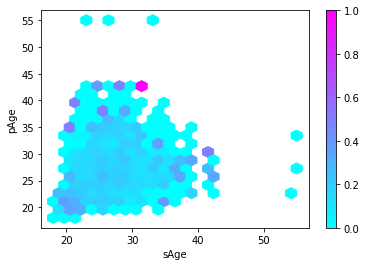

In [663]:
#1.1 
with_pAge(df).rename({'age':'sAge'}, axis='columns').plot.hexbin(
    x='sAge', y='pAge', C='match',
    cmap=plt.cm.cool, 
    reduce_C_function=np.mean, 
    gridsize=22,
    sharex=False, sharey=False)
plt.show()

In [664]:
X, Y = splitBy(df, 'dec')
X = preprocess(X.drop(columns=['gender']))

Dropping column field
Dropping column undergra
Dropping column from
Dropping column career


In [758]:
fem_model = model(X[df.gender == 1], Y[df.gender == 1], test_size=0.2, random_state=69)

Accuracy: 67.46%
True negatives: 41.36%	False negatives: 9.65%
False positives: 22.88%	True positives: 26.10%



In [759]:
fem_model_other = model(X[df.gender == 1], Y[df.gender == 1], test_size=0.2, random_state=42)

Accuracy: 67.22%
True negatives: 36.95%	False negatives: 15.49%
False positives: 17.28%	True positives: 30.27%



In [760]:
man_model = model(X[df.gender == 0], Y[df.gender == 0], test_size=0.2)

Accuracy: 67.38%
True negatives: 51.25%	False negatives: 12.78%
False positives: 19.83%	True positives: 16.13%



Accuracy: 68.50%
True negatives: 46.48%	False negatives: 12.71%
False positives: 18.79%	True positives: 22.02%



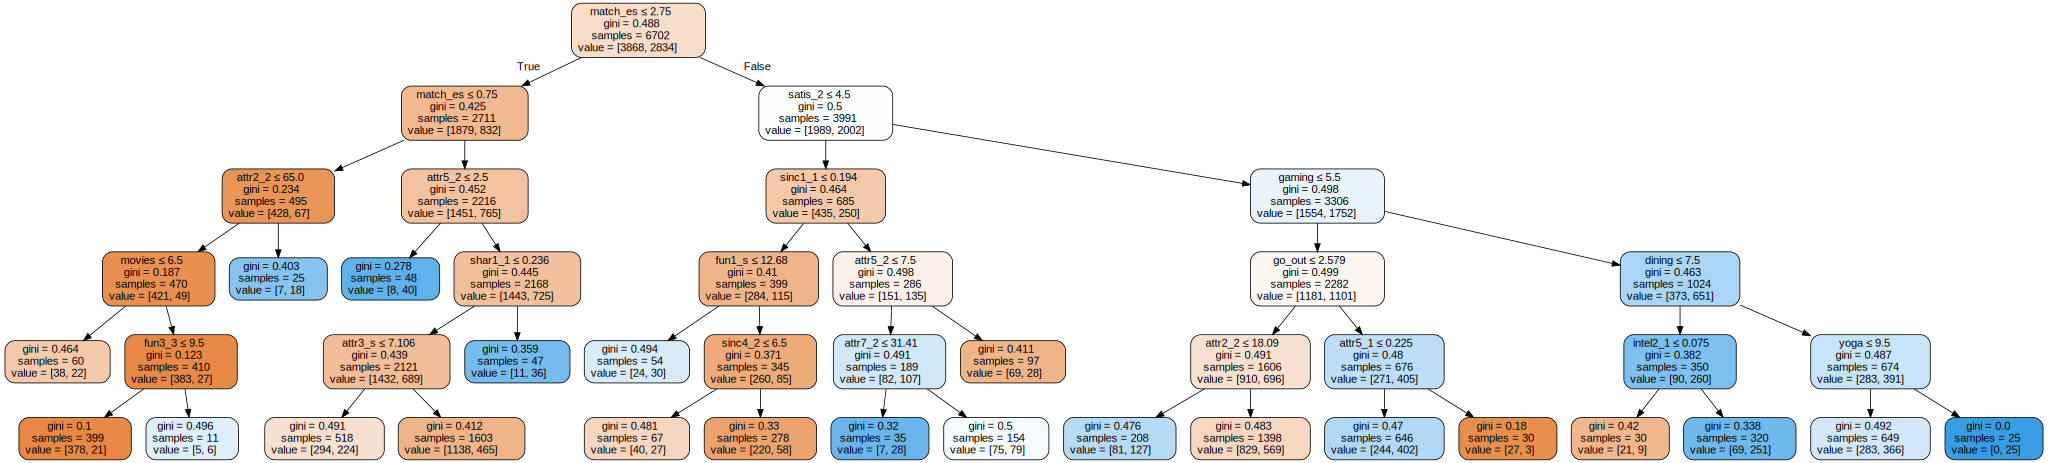

In [761]:
#2.1 
uni_model = model(X, Y, test_size=0.2)
vizualize(model(X, Y, test_size=0.2, max_depth=5, print_stats=False), X.columns)

In [669]:
# 1.3 
X_feat = preprocess(with_pAge(df).drop(columns=['gender']))
X_feat['ageDiff'] = X_feat[['pAge', 'age']].apply(lambda x: abs(x[0]-x[1]), axis=1)
X_feat = impute(X_feat.drop(columns=['pAge']))

Dropping column field
Dropping column undergra
Dropping column from
Dropping column career


In [762]:
fem_model_feat = model(X_feat[df.gender == 1], Y[df.gender == 1], test_size=0.2, random_state=42)

Accuracy: 68.53%
True negatives: 38.02%	False negatives: 14.42%
False positives: 17.04%	True positives: 30.51%



In [763]:
man_model_feat = model(X_feat[df.gender == 0], Y[df.gender == 0], test_size=0.2, random_state=42)

Accuracy: 64.52%
True negatives: 48.39%	False negatives: 15.05%
False positives: 20.43%	True positives: 16.13%



Accuracy: 68.56%
True negatives: 46.42%	False negatives: 12.77%
False positives: 18.68%	True positives: 22.14%



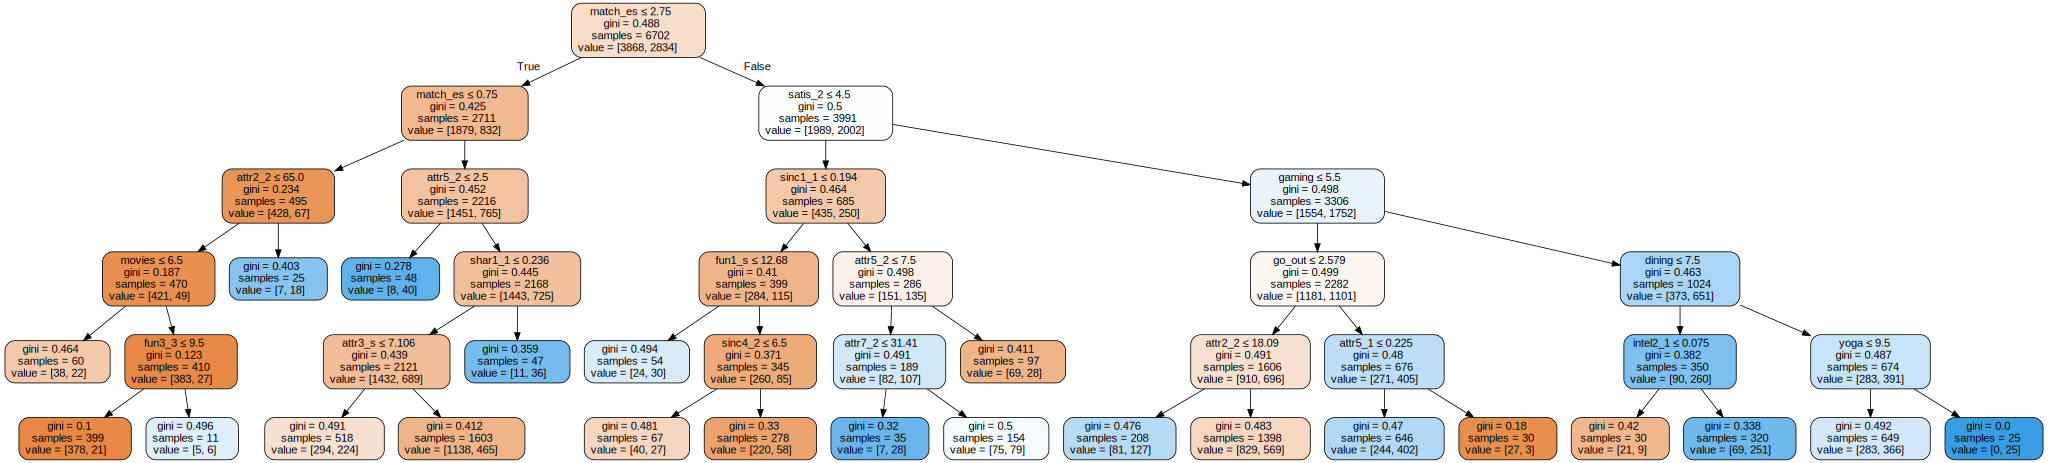

In [766]:
X_nobias = impute(X.drop(["race","imprace","imprelig","income"], axis=1))
nobias_model = model(X_nobias,Y, test_size=0.2)
vizualize(model(X_nobias,Y, max_depth=5, test_size=0.2, print_stats=False), X_nobias.columns)

In [768]:
def printDiscriminationScore(attr, d_uni, d_nobias):
    print("""Discrimination score(slift):
 Unisex model: {0}
 No bias model: {1}""".format(d_uni, d_nobias))

In [770]:
def discriminationScore(df):
    means = df[['dec','nobias_dec','uni_dec']].mean()
    d_uni = abs(means['dec']-means['uni_dec'])
    d_nobias = abs(means['dec']-means['nobias_dec'])    
    return d_uni, d_nobias

In [841]:
df_dec = impute(df.copy().drop(columns=['id']))

df_dec['uni_dec'] = uni_model.predict(X.as_matrix())
df_dec['nobias_dec'] = nobias_model.predict(X_nobias.as_matrix())

print()

display(df_dec.corr()[['uni_dec']].drop(['uni_dec']).sort_values(axis=1,ascending=False))
display(df_dec.corr()[['uni_dec']].drop(['uni_dec']))

printDiscriminationScore('gender', *discriminationScore(df_dec[df_dec.gender == 1]))

not_equal = df_dec[df_dec.nobias_dec != df_dec.uni_dec]
#display(not_equal.corr())

### Cases where model decisions differ
#display(not_equal[['gender', 'income', 'race', 'dec', 'nobias_dec', 'uni_dec']])

Dropping column field
Dropping column undergra
Dropping column from
Dropping column career



TypeError: sort_values() missing 1 required positional argument: 'by'

In [779]:
ax = df.plot.scatter(x='income', y='dec', color='DarkBlue', label='Group 1');
plt.show()

AttributeError: 'FramePlotMethods' object has no attribute 'column'